<a href="https://colab.research.google.com/github/akatukam/Agent-in-a-Grid/blob/main/Reinforcement_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!jupyter nbconvert --to html /hw_2_rein.ipynb

[NbConvertApp] Converting notebook /hw_2_rein.ipynb to html
[NbConvertApp] Writing 791193 bytes to /hw_2_rein.html


# Reinforcement Learning
Training a simple environment using Q-learning.


First we will use a popular python package called gymnasium to create a simple Grid World environment.

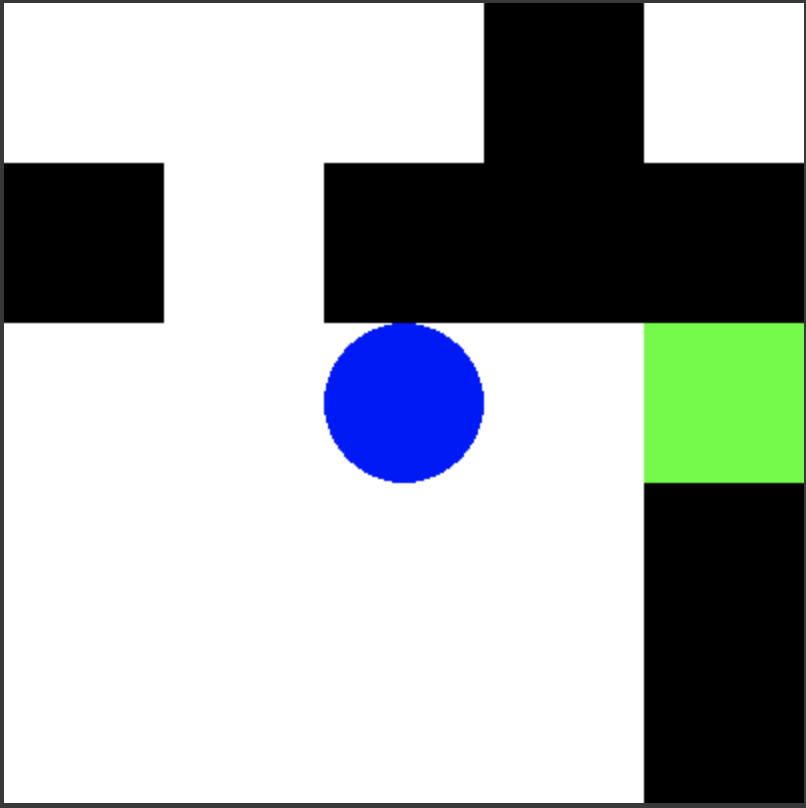

# Part 1: Implementing a Gymnasium Environment

We will start by implementing a simple gymnasium environment. You can find documentation for the whole package here https://gymnasium.farama.org/index.html#.

First let's install the necessary packaged

In [ ]:
# Install the necessary packages
!pip install gymnasium pyvirtualdisplay > /dev/null 2>&1
!pip install pygame

Next we'll import the packages needed

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

First we will initialize our new class. This class will need to take in 3 arguments. The width and height of the grid as well as the description for our grid world environment.


Our environment must be able to handle any given width and height as well as any given description. The description will come in the form of a string that specify the block order from left to right. There are three possible types of blocks.


1.   "I" specifies that a block should be ice
2.   "H" specifies that a block should be a hole
3.   "G" specifies that a block should be the goal.

For example an environment with width 3, height 3 and a description "IIHHIIIIG" looks like this

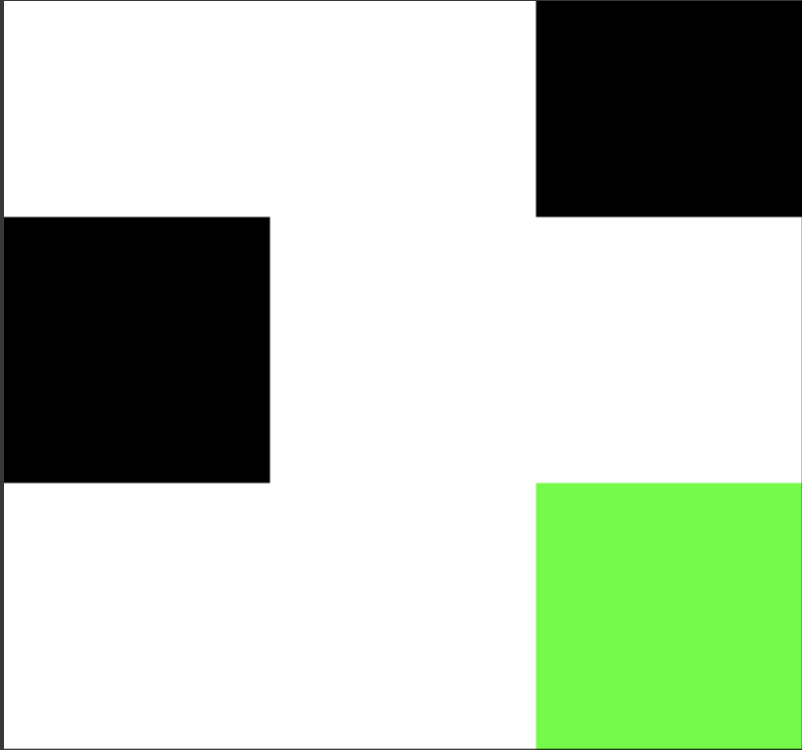

Every gymnasium class must define an observation and an action space of type "space." We can find a description of spaces here https://gymnasium.farama.org/api/spaces/.




In [ ]:
class FrozenLake(gym.Env):
  def __init__(self, grid_width, grid_height, grid_description):
      self.observation_space = spaces.Discrete(grid_width * grid_height)
      self.action_space = spaces.Discrete(4)
      self.grid = np.array(list(grid_description)).reshape((grid_height, grid_width))
      self.agent_position = [0,0]

      self.width = grid_width
      self.height = grid_height

The next method we will define for your class is the _get_obs method. This should return the observation for your environment.

In [ ]:
class FrozenLake(FrozenLake):
  def _get_obs(self):
      row, col = self.agent_position
      return row * self.width + col

Next, a reset function. This should return our environment to its original state.


In [ ]:
class FrozenLake(FrozenLake):
  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.agent_position = [0, 0]
    observation = self._get_obs()
    info = {}
    return observation, info

Now we write the method that will return the reward for a given observation.

In [ ]:
class FrozenLake(FrozenLake):
  def compute_reward(self, observation, moved_off_board):
      row, col = divmod(observation, self.width)
      grid_content = self.grid[row, col]

      if moved_off_board:
        return -5
      elif grid_content == "G":
          return 5
      elif grid_content == "H":
          return -1
      elif grid_content == "I":
          return -0.01
      else:
          return -1

Given an action we will want to modify the current state of your environment to account for the action. Additionally, given the observation and reward determine if the episode is over or not.

In [ ]:
class FrozenLake(FrozenLake):
  def step(self, action):

      initial_position = self.agent_position.copy()
      if action == 0 and self.agent_position[0] > 0:
              self.agent_position[0] -= 1
      elif action == 1 and self.agent_position[0] < self.height - 1:
              self.agent_position[0] += 1
      elif action == 2 and self.agent_position[1] > 0:
              self.agent_position[1] -= 1
      elif action == 3 and self.agent_position[1] < self.width - 1:
              self.agent_position[1] += 1

      moved_off_board = initial_position == self.agent_position
      if action > 3:
        moved_off_board = True

      observation = self._get_obs()
      reward = self.compute_reward(observation, moved_off_board)

      current_cell = self.grid[self.agent_position[0], self.agent_position[1]]
      if current_cell == 'G':
          terminated = True
      else:
          terminated = False
      return observation, reward, terminated, False, None

Use pygame to render our environment (https://www.pygame.org/docs/) and test it on an agent moving randomly.



In [ ]:
class FrozenLake(FrozenLake):
    def _render_frame(self, screen, window_width, window_height):
        box_width = window_width / self.width
        box_height = window_height / self.height
        screen.fill((0, 0, 0))

        for row in range(self.height):
            for col in range(self.width):
                color = (255, 255, 255)
                if self.grid[row, col] == 'H':
                    color = (255, 0, 0)
                elif self.grid[row, col] == 'G':
                    color = (0, 255, 0)
                pygame.draw.rect(screen, color, (col * box_width, row * box_height, box_width, box_height))


        agent_x = self.agent_position[1] * box_width + box_width / 2
        agent_y = self.agent_position[0] * box_height + box_height / 2
        pygame.draw.circle(screen, (255, 105, 180), (int(agent_x), int(agent_y)), int(min(box_width, box_height) / 4))

        border_color = (0, 0, 0)
        border_thickness = 3
        pygame.draw.rect(screen, border_color, (0, 0, window_width, window_height), border_thickness)

        pygame.display.flip()

    def render(self, screen, window_width, window_height):
        return self._render_frame(screen, window_width, window_height)


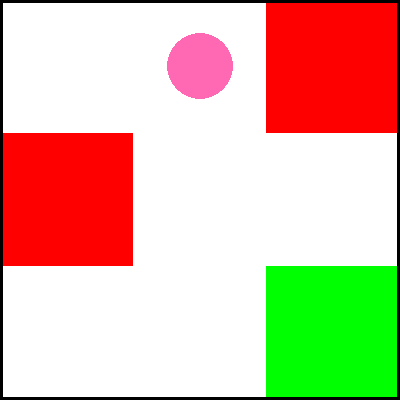

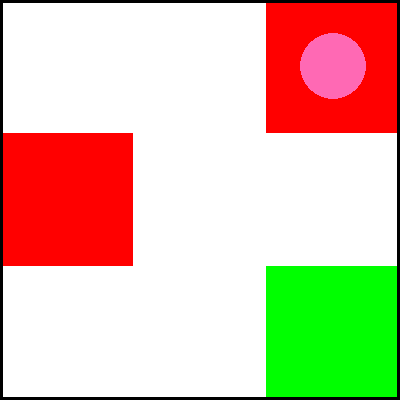

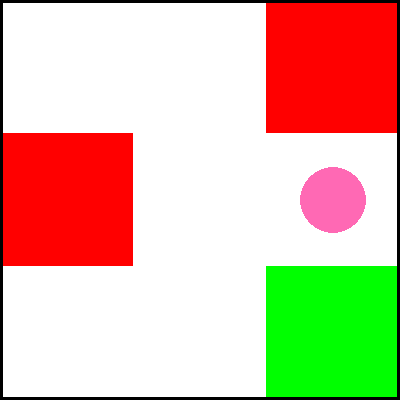

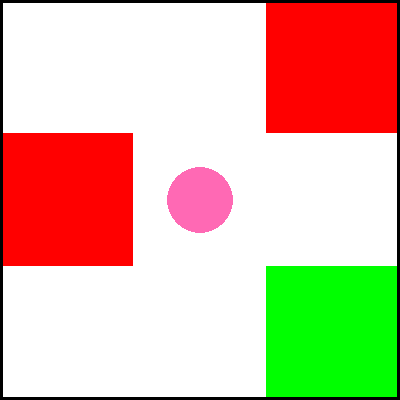

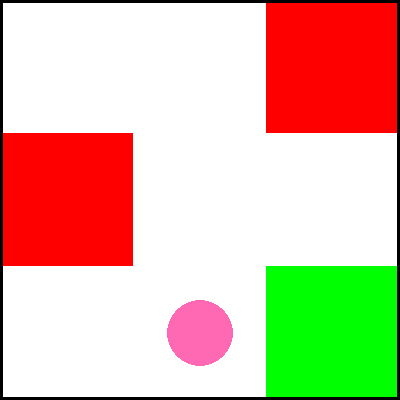

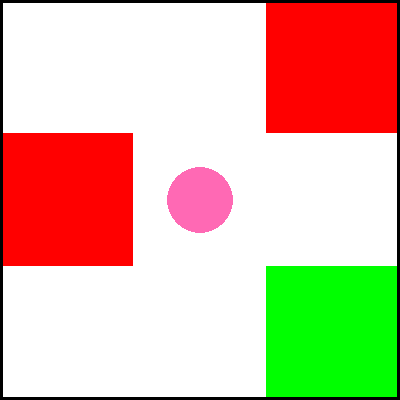

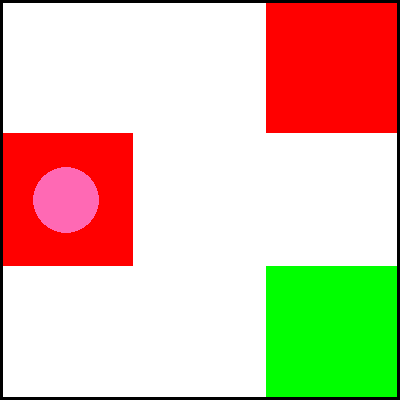

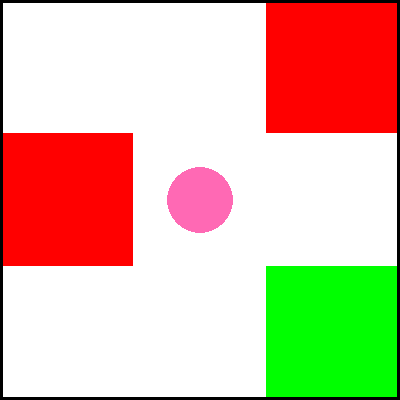

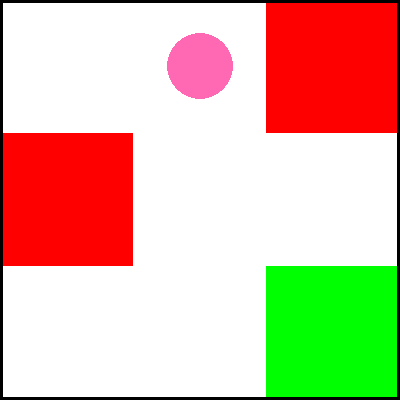

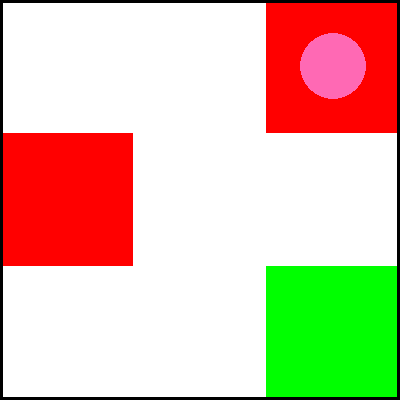

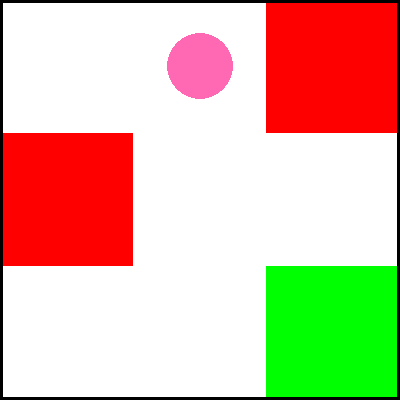

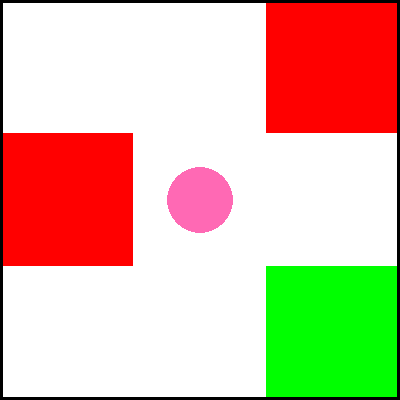

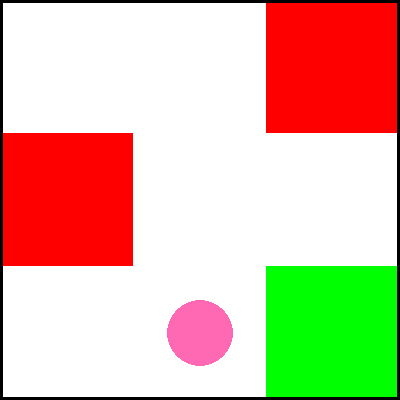

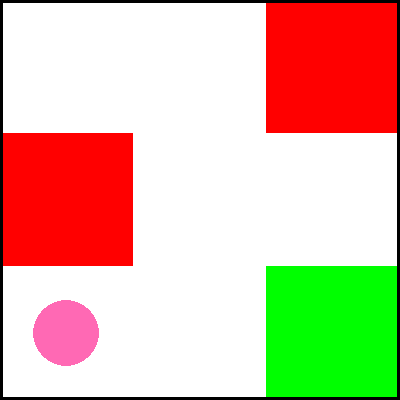

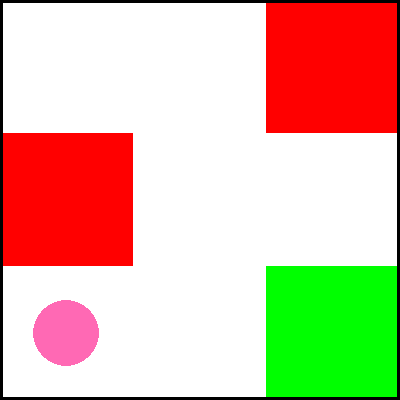

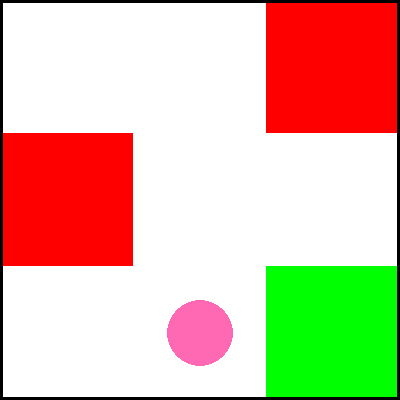

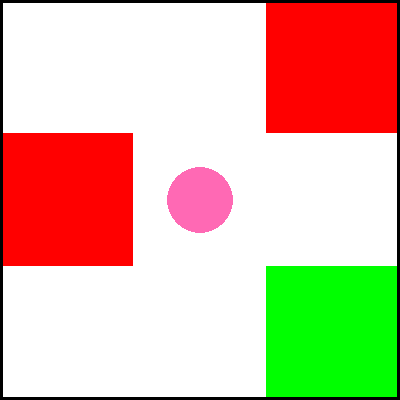

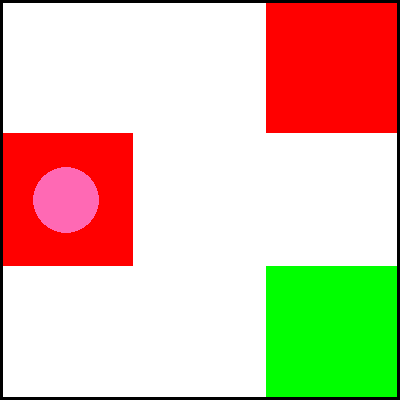

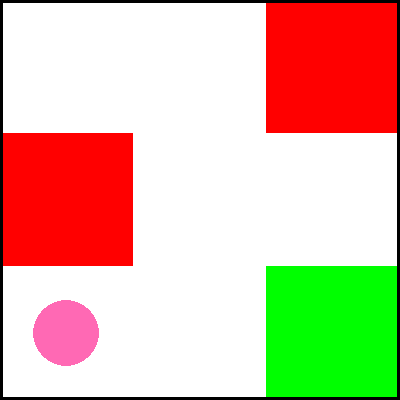

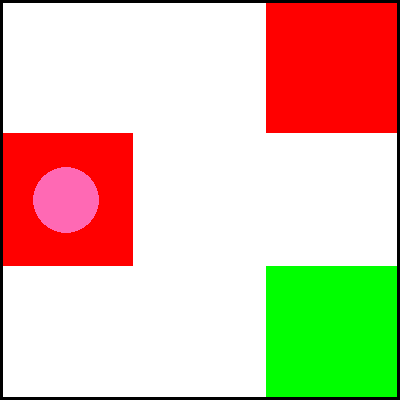

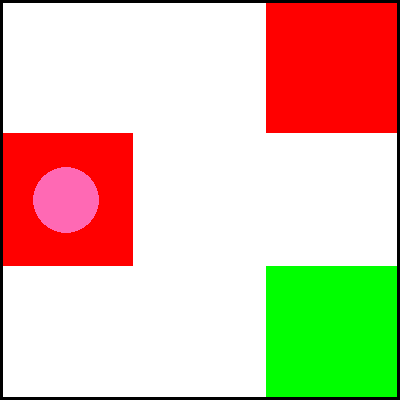

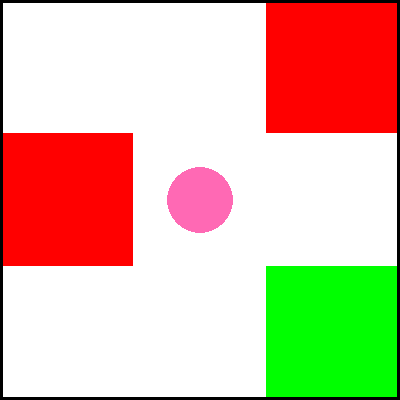

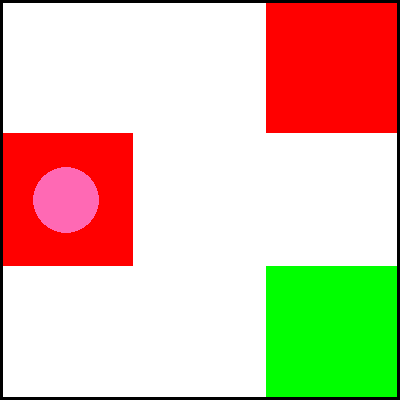

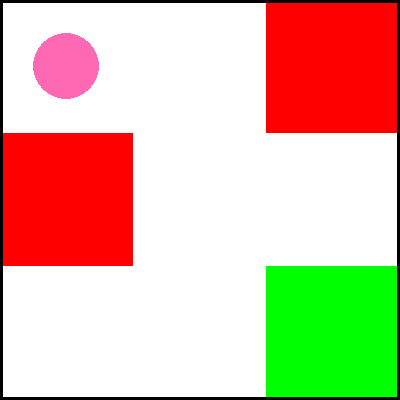

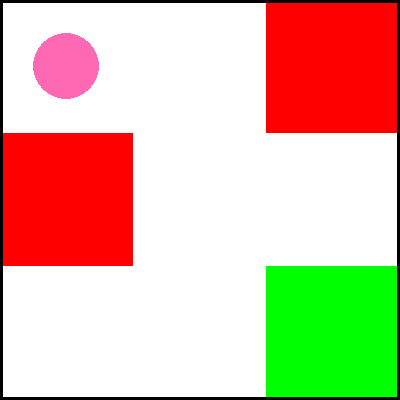

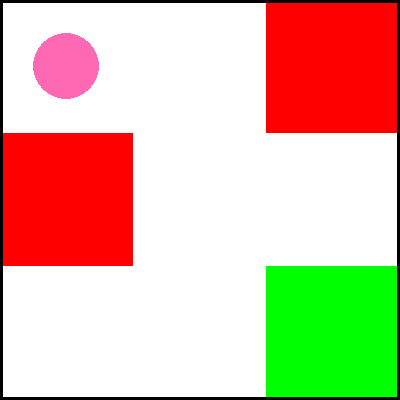

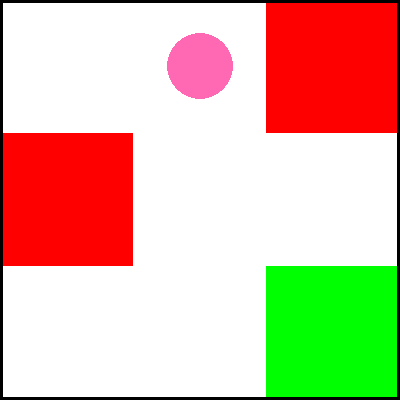

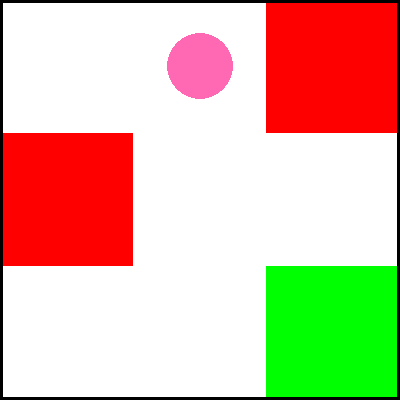

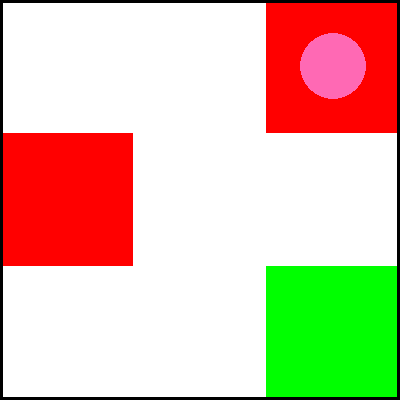

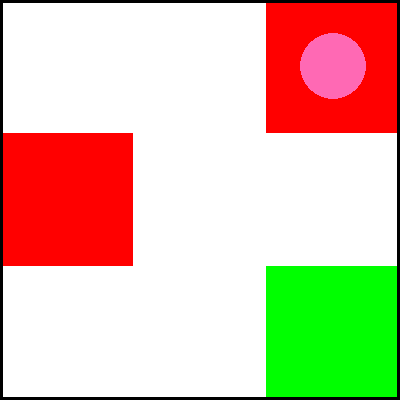

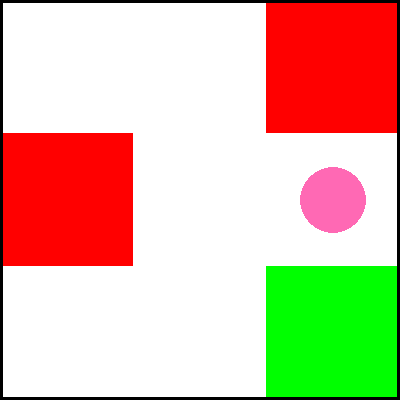

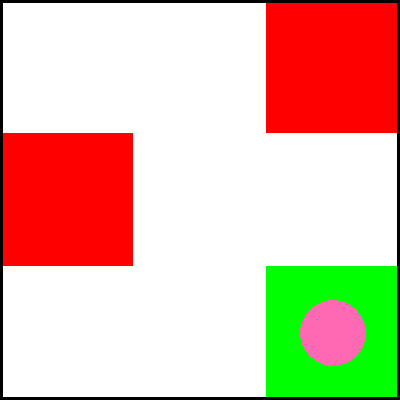

In [ ]:
import cv2
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import time

lake = FrozenLake(3, 3, "IIHHIIIIG")
window_width = 400
window_height = 400
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))

for i in range(0, 1):
  observation, info = lake.reset()
  terminated = False
  while not terminated:
    action = lake.action_space.sample()
    observation, reward, terminated, truncated, info = lake.step(action)
    lake.render(screen, window_width, window_height)

    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(.5)

# Part 2: Implement Q-Learning

We will implement a simple algorithm that should be able to solve any gymnasium environment with discrete observation and action spaces.

In the init function we will pass in the environment as well as the percentage of time the policy should explore versus exploit. We will also pass in gamma and alpha as defined in the bellman equation you learned in class. obs_space_n and action_space_n should represent the dimensions of the observation and action spaces.

In [ ]:
import random

class QLearning():
  def __init__(self, env, exploration, gamma, alpha, obs_space_n, action_space_n):
    self.env = env
    self.exploration = exploration
    self.gamma = gamma
    self.alpha = alpha
    self.q_table = np.zeros((obs_space_n, action_space_n))

Defining a method that should sample an action from the policy.

In [ ]:
class QLearning(QLearning):
  def sample_action(self, observation):
      if random.uniform(0, 1) < self.exploration:
          return self.env.action_space.sample()
      else:
          return np.argmax(self.q_table[observation])

Defining a method that updates our q-table.


In [ ]:
class QLearning(QLearning):
  def update_table(self, observation, action, reward, new_observation, terminated):
      max_q = np.max(self.q_table[new_observation])
      curr_q = self.q_table[observation, action]

      self.q_table[observation, action] =  (1 - self.alpha) * curr_q + self.alpha * (reward if terminated else reward + self.gamma * max_q)

Using the two classes defined below to train our policy so that it solves the environment.

In [ ]:
lake = FrozenLake(5, 5, "IIIHIHIHHHIIIIGIIIIHIIIIH")
q_learning = QLearning(lake, .3, .99, .9, lake.width * lake.height, lake.action_space.n)

num_episodes = 10000
max_episodes = 100
min_expl_prob = 0.01
expl_decay = 0.001
episode_rewards = []

for e in range(num_episodes):
    curr_state, _ = lake.reset()
    done = False
    tot_reward = 0

    for i in range(max_episodes):
        action = q_learning.sample_action(curr_state)
        next_state, reward, done, *_ = lake.step(action)
        q_learning.update_table(curr_state, action, reward, next_state, done)
        tot_reward += reward
        if done:
            break
        curr_state = next_state

    q_learning.exploration = max(min_expl_prob, np.exp(-expl_decay * e))
    episode_rewards.append(tot_reward)

This method should demonstrate a solved environment.

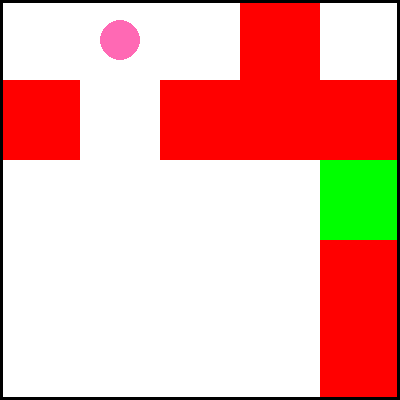

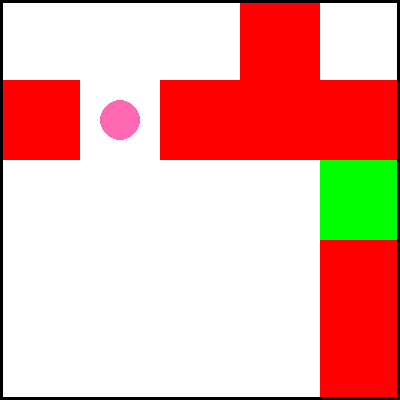

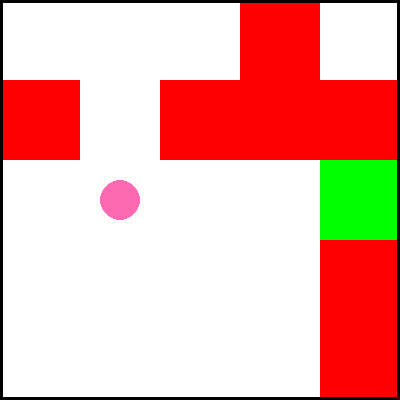

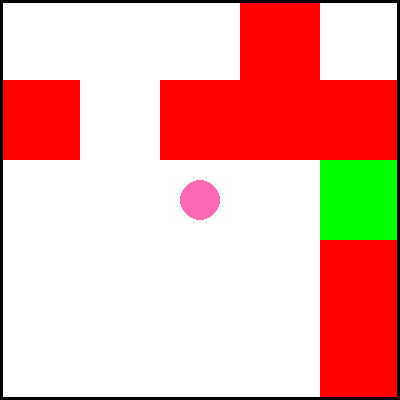

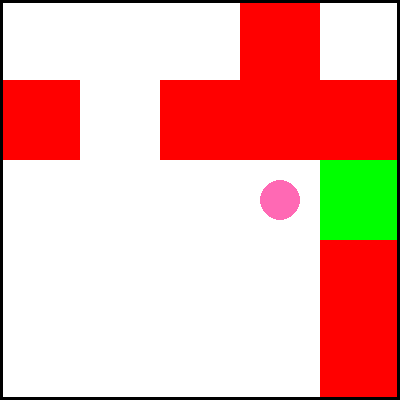

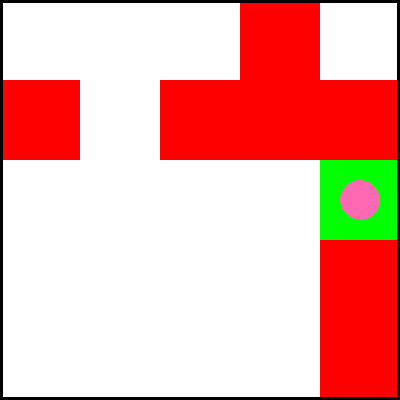

In [ ]:
q_learning.exploration = 0.0
for i in range(0, 1):
  observation, info = lake.reset()
  terminated = False
  lake.render(screen, window_width, window_height)
  view = pygame.surfarray.array3d(screen)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  cv2_imshow(img_bgr)
  time.sleep(.5)
  clear_output()
  while not terminated:
    action = q_learning.sample_action(observation)
    observation, reward, terminated, truncated, info = lake.step(action)
    lake.render(screen, window_width, window_height)

    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(.5)